In [ ]:
# import required libraries and packages
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log10, exp, pi

In [ ]:
# define "ground truth" function f(x) from 0 < x < 100
x = np.linspace(0,100,101)
y = np.sin(x/7) - np.cos(x**(1/1.4)) + 10**(-3.5)*(x-40)**2

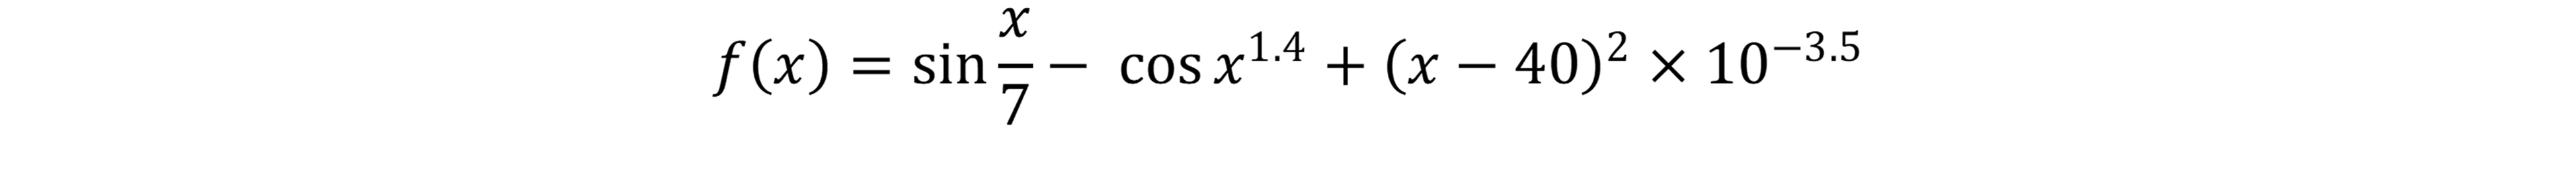

In [ ]:
# plot f(x)
plt.figure(figsize=(8,4))
plt.plot(x,y,label='f(x)',color='k')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
n_known = 5  # set number of known samples
np.random.seed(7) # set random seed for repeatable results

# define known x and y values
x_known = np.random.randint(0,100,n_known)
y_known = np.sin(x_known/7) - np.cos(x_known**(1/1.4)) + 10**(-3.5)*(x_known-40)**2

# plot f(x) with known data points
plt.figure(figsize=(8,4))
plt.plot(x,y,label='f(x)',color='k')
plt.scatter(x_known,y_known,label='Known',color='k')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# define kernel with Radial Basis Function and Gaussian Process Regressor model
# https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html
kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=40)

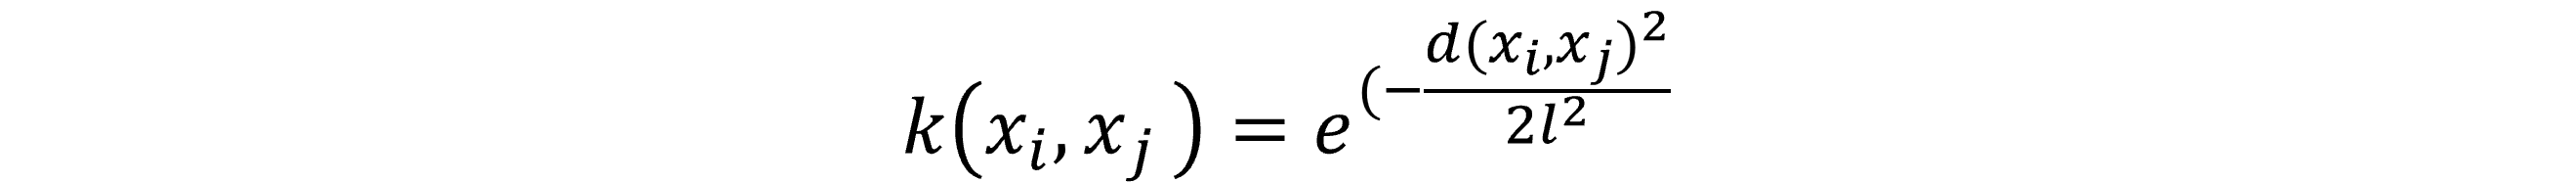

In [ ]:
# predict the y values for the full range 0 < x < 100
# our model is untrained, so there is no basis for any predictions
# this is called our "prior" distribution
y_prior, sigma_prior = gp.predict(x.reshape(-1,1), return_std = True)

# plot f(x) with prior distribution
plt.figure(figsize=(8,4))
plt.plot(x,y,label='f(x)',color='k')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_known,y_known,color='k')
plt.plot(x,y_prior, color = 'red', label = 'GPR', linestyle = '--')
plt.fill_between(x,y_prior - sigma_prior, y_prior + sigma_prior, alpha = 0.1, color = 'red')
plt.legend()
plt.show()

In [ ]:
# train model on the known data
gp.fit(x_known.reshape(-1,1),y_known)

# re-predict the distribution after training, this is our "posterior" distribution
y_post, sigma_post = gp.predict(x.reshape(-1,1), return_std = True)
plt.figure(figsize=(8,4))
plt.plot(x,y,label='f(x)',color='k')
plt.scatter(x_known,y_known,color='k')
plt.plot(x,y_post, color = 'red', label = 'GPR', linestyle = '--')
plt.fill_between(x,y_post - sigma_post, y_post + sigma_post, alpha = 0.1, color = 'red')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Acquisition Functions

### Upper Confidence Bound (UCB)

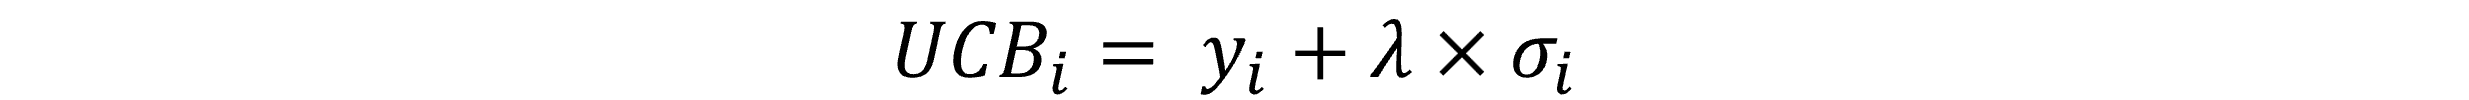

In [ ]:
# plot f(x) and known data points
plt.figure(figsize=(8,4))
plt.plot(x,y,label='f(x)',color='k')
plt.scatter(x_known,y_known,color='k')
plt.xlabel('x')
plt.ylabel('y')

# plot UCB with large lambda (favoring exploration)
lbda = 4
ucb = y_post + lbda*sigma_post
plt.plot(x,ucb,color = 'brown',label = '\u03bb = 4',linestyle='dotted')
plt.scatter(x=ucb.argmax(),y=ucb.max(),color='red',facecolors='none')

# plot UCB with moderate lambda (middle ground)
lbda = 2
ucb = y_post + lbda*sigma_post
plt.plot(x,ucb,color = 'darkgoldenrod',label = '\u03bb = 2',linestyle='dotted')
plt.scatter(x=ucb.argmax(),y=ucb.max(),color='red',facecolors='none')

# plot UCB with small lambda (favoring exploitation)
lbda = 1
ucb = y_post + lbda*sigma_post
plt.plot(x,ucb,color = 'gold',label = '\u03bb = 0',linestyle='dotted')
plt.scatter(x=ucb.argmax(),y=ucb.max(),color='red',facecolors='none')

plt.legend()
plt.show()

### Probability of Improvement (PI)

Probability distribution function:

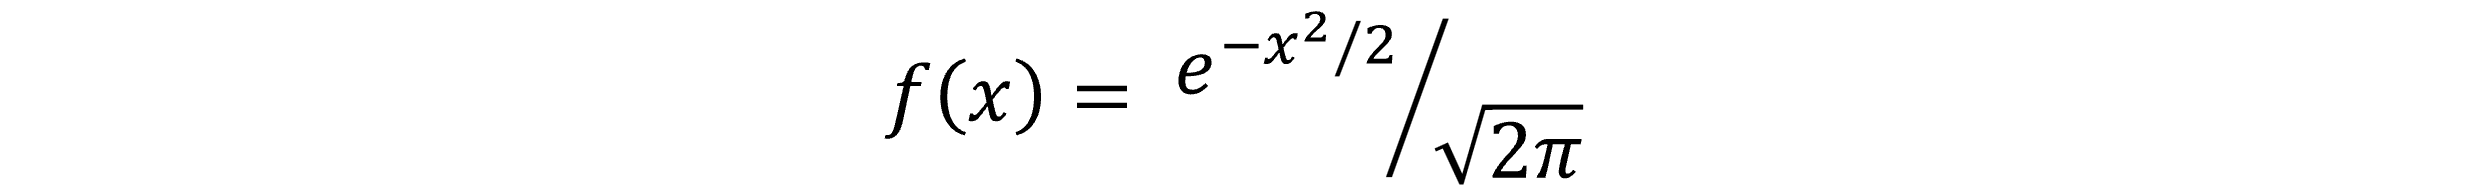

In [ ]:
# generate probability density
x_p = np.linspace(-3,3,100)
y_p = [exp(-(xp**2)/2)/(2*pi)**(1/2) for xp in x_p]

# plot probability density function
plt.figure(figsize=(8,4))
plt.plot(x_p,y_p,label='Prob. Dens.',color='k')

# plot cumulative distribution function
plt.plot(x_p,norm.cdf(x_p),label='Cum. Dist',color='gray',linestyle='dashed')
plt.xlabel('\u03C3')
plt.ylabel('Probability')
plt.legend()
plt.show()

z-score and Probability of Improvement:

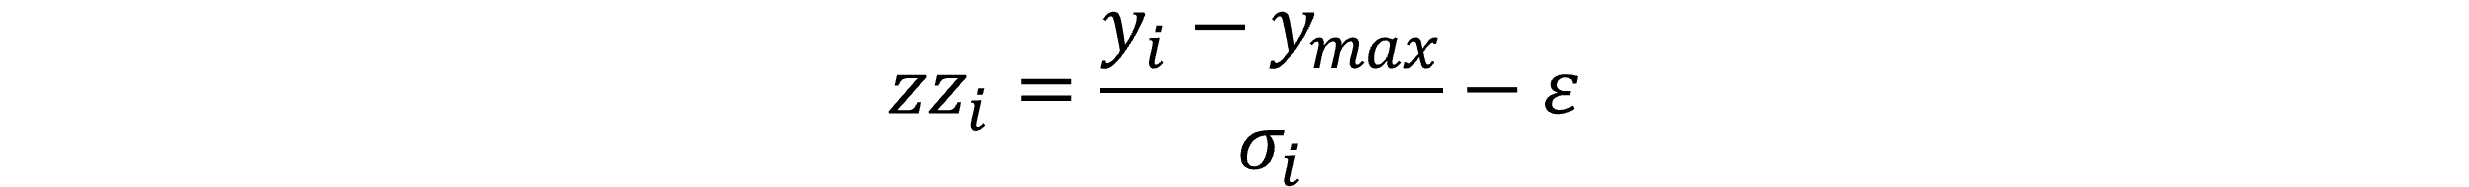

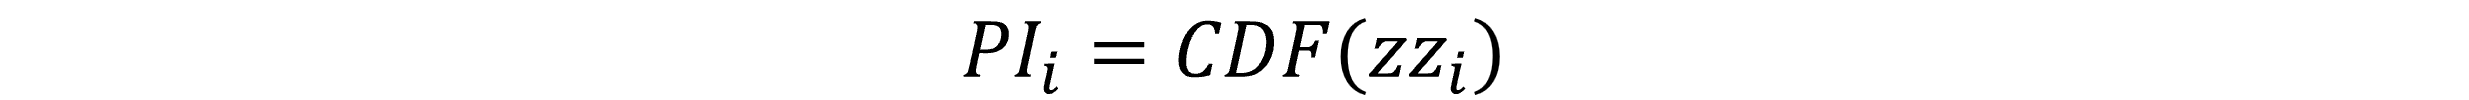

In [ ]:
# plot f(x) and known data points
plt.figure(figsize=(8,4))
plt.plot(x,y,label='f(x)',color='k')
plt.plot(x,y_post, color = 'red', label = 'Post', linestyle = '--')
plt.fill_between(x,y_post - sigma_post, y_post + sigma_post, alpha = 0.1, color = 'red')
plt.scatter(x_known,y_known,color='k')
plt.xlabel('x')
plt.ylabel('y')
ax2 = plt.twinx()

# determine the GPR best predicted value from the training set
y_best = gp.predict(x_known.reshape(-1,1)).max()

def PoI(y_post,sigma_post,y_best,epsilon):
    PI = np.empty(y_post.size,dtype=float)
    for i in range(0,y_post.size):
        if sigma_post[i] > 1e-4:
            zz = (y_post[i]-y_best-epsilon)/sigma_post[i]
            PI[i] = norm.cdf(zz)
        else:
            PI[i] = 0.0     
    return PI

# plot PI with large epsilon value (favoring exploration)
PI = PoI(y_post,sigma_post,y_best,5)
PI = PI/PI.max() # scale for visibility
ax2.plot(x,PI,color='navy',linestyle='dotted',label='\u03b5 = 5')
ax2.scatter(PI.argmax(),PI.max(),color='r',facecolors='none')

# plot PI with moderate epsilon value (middle ground)
PI = PoI(y_post,sigma_post,y_best,.5)
PI = PI/PI.max() # scale for visibility
ax2.plot(x,PI,color='blue',linestyle='dotted',label='\u03b5 = .5')
ax2.scatter(PI.argmax(),PI.max(),color='r',facecolors='none')

# plot PI with small epsilon value (favoring exploitation)
PI = PoI(y_post,sigma_post,y_best,0)
PI = PI/PI.max() # scale for visibilty
ax2.plot(x,PI,color='skyblue',linestyle='dotted',label='\u03b5 = 0')
ax2.scatter(PI.argmax(),PI.max(),color='r',facecolors='none')
ax2.set_ylabel('Prob. Imp.')
ax2.set_ylim(0,PI.max()*1.2)

plt.legend(loc='lower left')
plt.show()

### Expected Improvement (ExpI)

z-score and Expected Improvement

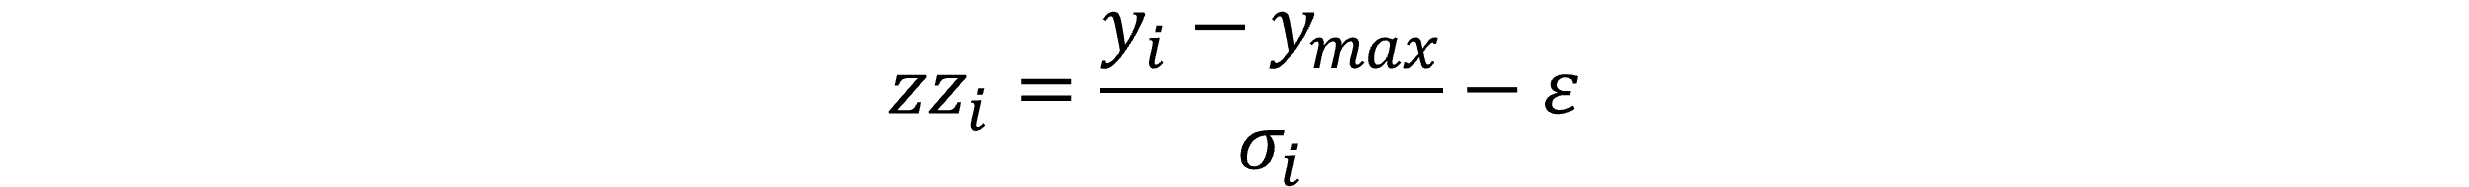

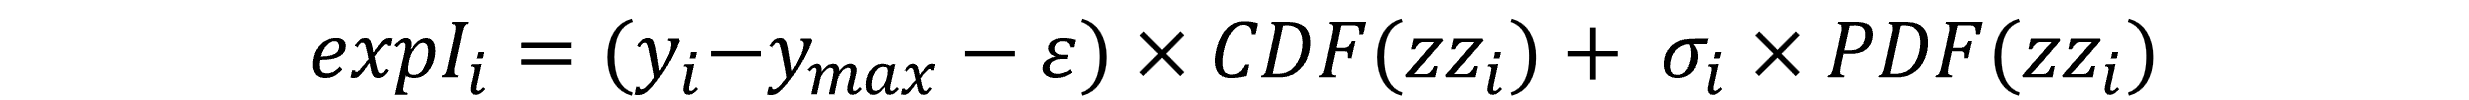

In [ ]:
# plot f(x) and known data points
plt.figure(figsize=(8,4))
plt.plot(x,y,label='f(x)',color='k')
plt.plot(x,y_post, color = 'red', label = 'Post', linestyle = '--')
plt.fill_between(x,y_post - sigma_post, y_post + sigma_post, alpha = 0.1, color = 'red')
plt.scatter(x_known,y_known,color='k')
plt.xlabel('x')
plt.ylabel('y')


# determine the GPR best predicted value from the training set
y_best = gp.predict(x_known.reshape(-1,1)).max()

def expI(y_post,sigma_post,y_best,epsilon):
    EI = np.empty(y_post.size,dtype=float)
    for i in range(0,y_post.size):
        if sigma_post[i] > 1e-4:
            zz = (y_post[i]-y_best-epsilon)/sigma_post[i]
            EI[i] = (y_post[i]-y_best-epsilon)*norm.cdf(zz,scale=1)+sigma_post[i]*norm.pdf(zz,scale=1)
        else:
            EI[i] = 0.0
    return EI

# plot PI with large epsilon value (favoring exploration)
ax2 = plt.twinx()
EI = expI(y_post,sigma_post,y_best,5)
EI = EI/EI.max() # scale for visibility
ax2.plot(x,EI,color='navy',linestyle='dotted',label='\u03b5 = 5')
ax2.scatter(EI.argmax(),EI.max(),color='r',facecolors='none')

# plot PI with moderate epsilon value (middle ground)
EI = expI(y_post,sigma_post,y_best,.5)
EI = EI/EI.max() # scale for visibility
ax2.plot(x,EI,color='blue',linestyle='dotted',label='\u03b5 = .5')
ax2.scatter(EI.argmax(),EI.max(),color='r',facecolors='none')

# plot PI with small epsilon value (favoring exploitation)
EI = expI(y_post,sigma_post,y_best,0)
EI = EI/EI.max() # scale for visibility
ax2.plot(x,EI,color='skyblue',linestyle='dotted',label='\u03b5 = 0')
ax2.scatter(EI.argmax(),EI.max(),color='r',facecolors='none')
ax2.set_ylabel('Expected Imp.')
ax2.set_ylim(0,EI.max()*1.2)

plt.legend(loc='lower left')
plt.show()

### Iteratively add new data and retrain the model

In [ ]:
# set how many loops to train
n_loops = 15

y_pred, sigma_pred = y_post, sigma_post
x_known2, y_known2 = x_known, y_known
fig, ax = plt.subplots(3,1)
fig.set_figwidth(8)
fig.set_figheight(9)
mae = [abs((y_pred-y)).mean()]

# plot current GPR fit
ax[0].set_title(f'Model after {n_loops} Active Learning cycles')
ax[0].plot(x,y_pred, label = f'GPR 0', linestyle = '--',alpha=1)

for loop in range(n_loops):
    
    # determine the most valuable point by expected improvement
    EI = expI(y_pred,sigma_pred,y_best,.5)
    x_new = np.array([EI.argmax()])
    y_new = y[[EI.argmax()]]

    # add the new data point to the known data
    x_known2 = np.concatenate((x_known2,x_new))
    y_known2 = np.concatenate((y_known2,y_new))

    # re-train model on the new full data set and predict a new fit
    gp.fit(x_known2.reshape(-1,1),y_known2)
    y_pred,sigma_pred = gp.predict(x.reshape(-1,1),return_std = True)

    # determine the GPR best predicted value from the new training set
    y_best = gp.predict(x_known2.reshape(-1,1)).max()

    # plot new GPR fit
    ax[0].plot(x,y_pred, label = f'GPR {loop+1}', linestyle = '--',alpha=1,zorder=loop)
    
    # calculate MAE of model
    mae.append(abs((y_pred-y)).mean())
    
# plot f(x), the newest training point, and standard deviation for last model trained
ax[0].plot(x,y,color='k',zorder=0)
ax[0].scatter(x_known2,y_known2,color='k')
ax[0].fill_between(x,y_pred - sigma_pred, y_pred + sigma_pred, alpha = 0.1, color = 'red',zorder=0)
ax[0].legend(loc='lower right')
if n_loops>0:
    ax[0].scatter(x_new,y_new,color='r',zorder=10)

#determine the most valuable point for the new model by expected improvement
EI = expI(y_pred,sigma_pred,y_best,.5)

# plot the expected improvement graph highlighting the next training point
ax[1].bar(x,EI,color='black')
ax[1].scatter(EI.argmax(),EI.max(),color='red',facecolors='none',label='Best')
ax[1].set_ylabel('Exp. Impr.')
ax[1].set_xlabel('x')
ax[1].legend()

# plot the MAE
ax[2].scatter(range(len(mae)),mae,color='k')
ax[2].plot(mae,color='k')
ax[2].set_ylabel('MAE')
ax[2].set_xlabel('Cycle')
ax[2].set_xlim(-0.1,len(mae)-0.9)
ax[2].text(x=0.99,y=0.8,s=f'MAE = {round(mae[-1],3)}',transform=ax[2].transAxes,ha='right')
plt.tight_layout()
plt.show()